In [ ]:
import pandas as pd

In [23]:
import sys

# DEA tools
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/grits/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# grits
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/grits/')
from grits import zscore_dataset, humanbytes, get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices


In [ ]:


%%time
# the basics
import rich.table

# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import odc.stac
import stackstac
from xrspatial import zonal_stats

### get farms

In [ ]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

In [ ]:
field = gpd.read_file( path + 'fazenda_uniguiri.gpkg')
bbox, lat_range, lon_range = get_lims(field)

print(field.head())
field.plot()

In [14]:
# para um grupo dentro de uma farm
layer = 'piquetes_tid'
column = 'Re'
val = 80000

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg' , layer=layer)
field = field[field[column] == val]

bbox, lat_range, lon_range = get_lims(field)

print(field.head())

# plotting a partir do TID
# IT DOESN'T WORK ON VSCODE
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'TID',cmap='Set1', **style )

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


Label(value='')

Map(center=[-16.955265352726073, -54.57066140325033], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [17]:
datetime = "2022-07-10/2023-10-10"
max_cloud_cover = 30
items = query_l2a_items(bbox, datetime, max_cloud_cover)

 found 42 items


In [18]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"], 
        chunksize=256,
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})
data

<xarray.DataArray 'stackstac-14e97161688b87eb5ffd28d150b5408e' (time: 42,
                                                                band: 8,
                                                                latitude: 173,
                                                                longitude: 161)>
dask.array<where, shape=(42, 8, 173, 161), dtype=float64, chunksize=(1, 1, 173, 161), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.58 ... -...
  * latitude                                 (latitude) float64 -16.95 ... -1...
    s2:cloud_shadow_percentage               (time) float64 9.578 0.0 ... 3.846
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    proj:bbox                                object {699960.0, 809760.0, 8090...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.57825604339398, -16.963...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

In [19]:
#create MASK versao dataarray
masked = True

if masked:
    mask = xr_rasterize(field,data,
                        # x_dim='x',
                        # y_dim='y',
                       #export_tiff='masked2.tiff',
                       ) 

    # #mask data
    data = data.where(mask)

    # #convert to float 32 to conserve memory
    data = data.astype(np.float32)
data

<xarray.DataArray 'stackstac-14e97161688b87eb5ffd28d150b5408e' (time: 42,
                                                                band: 8,
                                                                latitude: 173,
                                                                longitude: 161)>
dask.array<astype, shape=(42, 8, 173, 161), dtype=float32, chunksize=(1, 1, 173, 161), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.58 ... -...
  * latitude                                 (latitude) float64 -16.95 ... -1...
    s2:cloud_shadow_percentage               (time) float64 9.578 0.0 ... 3.846
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    proj:bbox                                object {699960.0, 809760.0, 8090...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.57825604339398, -16.963...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

In [21]:
# converte o dataarray em dataset
ds_ = data.to_dataset(dim='band') 

# calcula os indices
indices = ["LAI", "EVI","NDCI", "BSI"]
ds = calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

humanbytes(ds.nbytes)

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


'17.91 MB'

In [24]:
zscores = zscore_dataset(ds)
humanbytes(zscores.nbytes)

'17.91 MB'

In [25]:
zscores

<xarray.Dataset>
Dimensions:                                  (time: 42, longitude: 161,
                                              latitude: 173, band: 8)
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2022-07-12...
    id                                       (time) <U54 'S2B_MSIL2A_20220712...
  * longitude                                (longitude) float64 -54.58 ... -...
  * latitude                                 (latitude) float64 -16.95 ... -1...
    s2:cloud_shadow_percentage               (time) float64 9.578 0.0 ... 3.846
    s2:product_uri                           (time) <U65 'S2B_MSIL2A_20220712...
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    proj:bbox                                object {699960.0, 809760.0, 8090...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Dimensions without coordinates: band
Data variables:
    LAI                                      (time, latitude, longitude) float32 dask.array<chunksize=(1, 173, 161), meta=np.ndarray>
    EVI                                      (time, latitude, longitude) float32 dask.array<chunksize=(1, 173, 161), meta=np.ndarray>
    NDCI                                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 173, 161), meta=np.ndarray>
    BSI                                      (time, latitude, longitude) float32 dask.array<chunksize=(1, 173, 161), meta=np.ndarray>

In [31]:
%%time
# para os IVs
qmin_qmax=[0.02, 0.98]
mms = get_mms(ds, indices, qmin_qmax)

{'LAI': array([0.3128237 , 2.53853302]), 'EVI': array([0.11907786, 0.73425453]), 'NDCI': array([0.08723913, 0.55277329]), 'BSI': array([-0.20552925,  0.19869156])}
CPU times: user 6.09 s, sys: 996 ms, total: 7.09 s
Wall time: 26.2 s


In [32]:
mms

{'LAI': array([0.3128237 , 2.53853302]),
 'EVI': array([0.11907786, 0.73425453]),
 'NDCI': array([0.08723913, 0.55277329]),
 'BSI': array([-0.20552925,  0.19869156])}

In [33]:
%%time
# para os ZSCORES
qmin_qmax=[0.02, 0.98]
mmsz = get_mms(zscores, indices, qmin_qmax)

{'LAI': array([-1.63819741,  2.16065421]), 'EVI': array([-1.63819753,  2.16065359]), 'NDCI': array([-1.64593047,  2.31860702]), 'BSI': array([-2.29066715,  1.78395503])}
CPU times: user 6.27 s, sys: 965 ms, total: 7.24 s
Wall time: 26.1 s


In [34]:
i1,i2,i3 = 'NDCI','BSI','LAI'

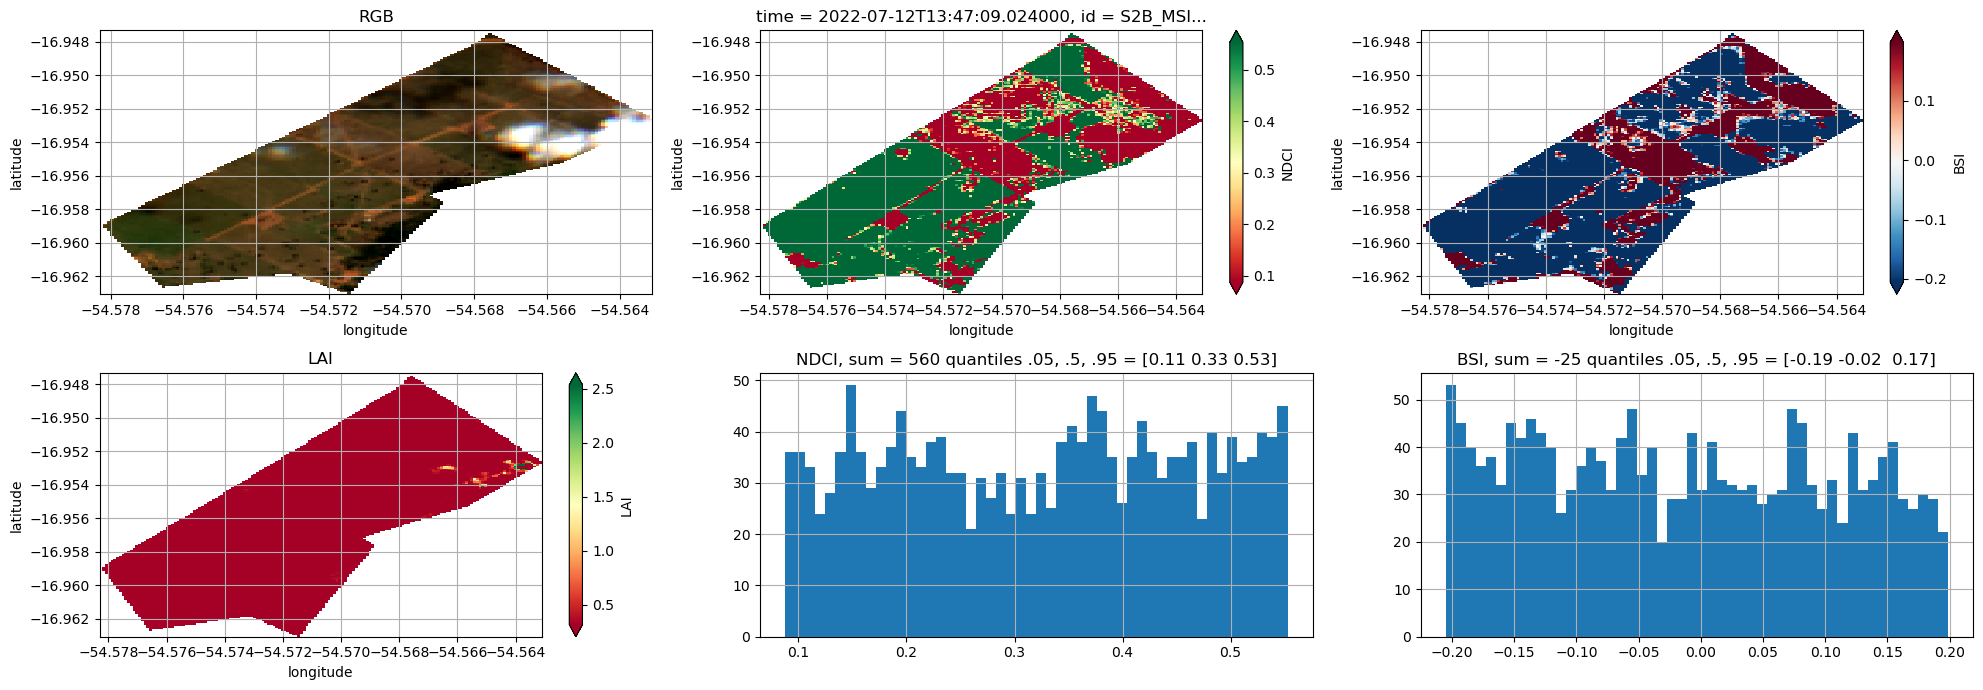

In [37]:
# plot ZSCORES using time slice
timeslice = False

if timeslice:
    zscores_ = zscores.sel(time=slice("2022-06-15", "2023-07-31")).copy(deep=True)
    step = 1
    
if not timeslice:
    zscores_ = zscores.copy()
    step = 90


for t in range(0, len(zscores.time),step):

    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6))  = plt.subplots(2, 3,figsize=(20,7))

    # RGB
    rgb(ds_,index=[t],percentile_stretch=(0.02,0.98), ax=ax1, aspect=1)
    ax1.set_title('RGB')
    ax1.grid()

    # i1 plot
    zscores_[i1].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i1][0], vmax = mms[i1][1], ax=ax2)
    ax2.grid()

    # i1 histogram
    flat = zscores_[i1].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i1][1]) | (flat < mms[i1][0]), np.nan, flat)
    ax5.hist(flat,50)
    ax5.grid()
    ax5.set_title(f'{i1}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i2 plot
    # por ser 'BSI', uso a escala invertida
    zscores_[i2].isel(time=[t]).plot(cmap = 'RdBu_r', vmin = mms[i2][0], vmax = mms[i2][1], ax=ax3)
    ax3.set_title(None);
    ax3.grid()

    # i2 histogram
    flat = zscores_[i2].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i2][1]) | (flat < mms[i2][0]), np.nan, flat)
    ax6.hist(flat, bins=50)
    ax6.grid()
    ax6.set_title(f'{i2}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i3 plot
    zscores_[i3].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i3][0], vmax = mms[i3][1], ax=ax4)
    ax4.set_title(i3);
    ax4.grid()

    fig.tight_layout();   
    plt.show();plt.close()